In [388]:
%matplotlib inline

import matplotlib
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

In [389]:
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_train = fetch_20newsgroups(subset='all', categories=comp_categories, shuffle=True, random_state=42)
rec_train = fetch_20newsgroups(subset='all', categories=rec_categories, shuffle=True, random_state=42)
# comp_test = fetch_20newsgroups(subset='test', categories=comp_categories, shuffle=True, random_state=42)
# rec_test = fetch_20newsgroups(subset='test', categories=rec_categories, shuffle=True, random_state=42)

#all_points = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, random_state=42)



In [390]:
# 1. transform the documents into TF-IDF vectors. 
# Use min df = 3, exclude the stopwords (no need to do stemming). Report the dimensions of the TF-IDF matrix you get.
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(min_df=3, stop_words=text.ENGLISH_STOP_WORDS) 
vectorized_corpus = vectorizer.fit_transform(comp_train.data + rec_train.data)

tfidf_transformer = TfidfTransformer()
trainX = tfidf_transformer.fit_transform(vectorized_corpus)

# testX = tfidf_transformer.transform(vectorizer.transform(comp_test.data + rec_test.data))

# 0 for comp class, 1 for rec class
trainy = np.zeros(shape=(len(comp_train.filenames) + len(rec_train.filenames),))
trainy[len(comp_train.filenames):] = 1

# testy = np.zeros(shape=(len(comp_test.filenames) + len(rec_test.filenames),))
# testy[len(comp_test.filenames):] = 1

In [391]:
print trainX.shape, trainy.shape

(7882, 27768) (7882,)


In [393]:
# 2. Apply K-means clustering with k = 2 using the TF-IDF data.
# Compare the clustering results with the known class labels.
# a) Inspect the contingency matrix to get a sense of your clustering result.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import contingency_matrix

km = KMeans(n_clusters=2, init='k-means++', max_iter=100)
km.fit(trainX)
ypred = km.predict(trainX)

In [394]:
print km.labels_.shape, testy.shape
print contingency_matrix(trainy, ypred, eps=None, sparse=False)

(7882,) (3150,)
[[3899    4]
 [2262 1717]]


In [395]:
# b) 5 Metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(trainy, ypred))
print("Completeness: %0.3f" % metrics.completeness_score(trainy, ypred))
print("V-measure: %0.3f" % metrics.v_measure_score(trainy, ypred))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(trainy, ypred))
print("Adjusted Mutual Info: %0.3f" % metrics.adjusted_mutual_info_score(trainy, ypred))

Homogeneity: 0.253
Completeness: 0.335
V-measure: 0.288
Adjusted Rand-Index: 0.181
Adjusted Mutual Info: 0.253


In [396]:
# 3. a) Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.
from scipy.sparse.linalg import svds

#Use SVD to find 1000 principal components
u, singular_values, vt = svds(trainX, k=1000)
print(len(singular_values))


1000


Text(0,0.5,u'retained variance ratio')

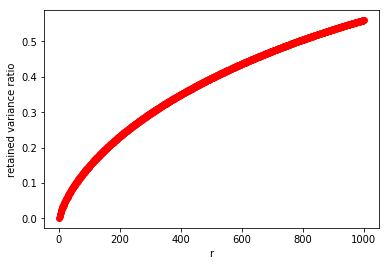

In [397]:
from sklearn.decomposition import TruncatedSVD, NMF

rs = np.arange(1, 1001)

svd = TruncatedSVD(n_components=1000)
svd.fit(trainX)
explained_vars = svd.explained_variance_ratio_

variances = np.zeros(explained_vars.shape)
variances[0] = explained_vars[0]
for i in range(1,1000):
    variances[i] = explained_vars[i] + variances[i-1]
    
plt.plot(rs, variances, 'ro')
plt.xlabel('r')
plt.ylabel('retained variance ratio')

In [411]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn import metrics


def get_scores(y, yhat):
    cont_matrix = contingency_matrix(y,yhat)# ypred)

    homogeneity = metrics.homogeneity_score(y, yhat)
    completeness_score = metrics.completeness_score(y, yhat)
    v_measure_score = metrics.v_measure_score(y, yhat)
    adjusted_rand_score = metrics.adjusted_rand_score(y, yhat)
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y, yhat)
    return cont_matrix, homogeneity, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
   
    
def get_svd_scores(k,train_lsi=None, test_lsi=None, trainy=trainy, n_clusters=2):
    svd = TruncatedSVD(n_components=k)
    if train_lsi is None and test_lsi is None:
        train_lsi = svd.fit_transform(trainX)
#        test_lsi = svd.transform(testX)

    km = KMeans(n_clusters).fit(train_lsi)
#     km.fit(train_lsi)

    ypred = km.predict(train_lsi)
    return get_scores(trainy, ypred)
#     svd = TruncatedSVD(n_components=40)
#     X = svd.fit_transform(trainX)
#     kmeans = KMeans(n_clusters=2).fit(X)
#     svd2 = TruncatedSVD(n_components=2)
#     X2 = svd2.fit_transform(X)


    
def get_nmf_scores(num_components, train_nmf=None, test_nmf=None,trainy=trainy, n_clusters=2):
    nmf = NMF(n_components=num_components)
    if train_nmf is None and test_nmf is None:
        print("Using default NMF transform...")
        train_nmf = nmf.fit_transform(trainX)
      #  test_nmf = nmf.transform(testX)
    
    km = KMeans(n_clusters).fit(train_nmf)
    ypred = km.predict(train_nmf)
  
    return get_scores(trainy, ypred)
    

Text(0,0.5,u'singular val')

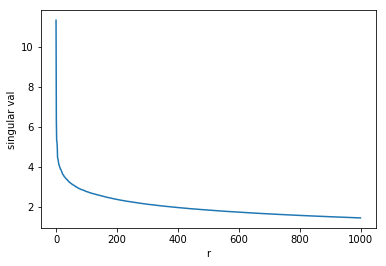

In [403]:
#print(sorted(singular_values, reverse=True))
sorted_singular_vals = sorted(singular_values, reverse=True)
plt.plot(sorted_singular_vals)
plt.xlabel('r')
plt.ylabel('singular val')

LSI...
('contingency matrix for r=', 1)
[[1703 2200]
 [1656 2323]]
('contingency matrix for r=', 2)
[[3713  190]
 [ 473 3506]]
('contingency matrix for r=', 3)
[[3866   37]
 [1422 2557]]
('contingency matrix for r=', 5)
[[3898    5]
 [2446 1533]]
('contingency matrix for r=', 10)
[[3900    3]
 [2374 1605]]
('contingency matrix for r=', 20)
[[   3 3900]
 [1607 2372]]
('contingency matrix for r=', 40)
[[3900    3]
 [2336 1643]]
('contingency matrix for r=', 50)
[[3900    3]
 [2353 1626]]
('contingency matrix for r=', 100)
[[3900    3]
 [2324 1655]]
('contingency matrix for r=', 300)
[[   4 3899]
 [1684 2295]]
r: 1 
 homogeneity=0.00030 
 completeness=0.00030 
 v-measure=0.00030 
 adj rand index=0.00034 
 adj mutual info=0.00021 
---
r: 2 
 homogeneity=0.59263 
 completeness=0.59424 
 v-measure=0.59343 
 adj rand index=0.69180 
 adj mutual info=0.59259 
---
r: 3 
 homogeneity=0.40097 
 completeness=0.43866 
 v-measure=0.41897 
 adj rand index=0.39656 
 adj mutual info=0.40091 
---
r: 5 
 

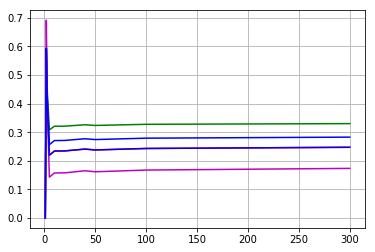

In [404]:
# b) LSI vs. NMF
# Specifically, try r = 1, 2, 3, 5, 10, 20, 40, 50, 100, 300, and plot the 5 
# measure scores v.s. r for both SVD and NMF; also report the contingency matrices for each r.
# Report the best r choice for SVD and NMF respectively.
# How do you explain the non-monotonic behavior of the measures as r increases?

r_vals = [1,2,3,5,10,20,40,50,100,300]
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
print("LSI...")
for r in r_vals:
    contin, h, c, v, rand, mutual = get_svd_scores(k=r)
#    contingency_matrices.append(contin)
    print("contingency matrix for r=", r)
#    print(h, c, v, rand, mutual)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list)) # not sure if this works e.g. [0,1,0,3,2,0]
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()
    
    



# Report the best r choice for SVD
The best r choice for SVD was r=40. The metric outputs were:<br>
r: 40<br>
 homogeneity=0.77681 <br>
 completeness=0.77714 <br>
 v-measure=0.77697 <br>
 adj rand index=0.86065 <br> 
 adj mutual info=0.77677

In [ ]:
print("NMF...")   
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
# r_vals = [2,3,4,5]
for r in r_vals:
    contin, h, c, v, rand, mutual = get_nmf_scores(num_components=r)
    print("contingency matrix for r=", r)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))


res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()




# Report the best r choice for NMF
The best r-choice for NMF was r=2.
<br>
r: 2  <br>
 homogeneity=0.59932  <br>
 completeness=0.59959 <br>
 v-measure=0.59946 <br>
 adj rand index=0.70657 <br> 
 adj mutual info=0.59923  <br>

# How do you explain the non-monotonic behavior of the measures as r increases?
As we increase the number of dimensions r, more information is encapsulated in the feature representation just by nature of having a higher percentage of the variance due to more principal components. However, K-Means suffers from the curse of dimensionality, so as the dimensions increase, Euclidean distance becomes a worse and worse distance metric and will perform poorly. Thus, we are trading off between more information and an inherent shortcoming in the KMeans method. This is why it's possible for KMeans to perform better with lower dimension (such as r=2) than with higher dimension (such as r=300 or r=1000).


In [45]:
#4a 
from sklearn.preprocessing import scale

#SVD
svd = TruncatedSVD(n_components=2)
train_lsi = svd.fit_transform(trainX)
test_lsi = svd.transform(testX)

km = KMeans(n_clusters=2)
km.fit(train_lsi)
ypred = km.predict(test_lsi)

#NMF
nmf = NMF(n_components=2)
train_nmf = nmf.fit_transform(trainX)
test_nmf = nmf.transform(testX)

km_nmf = KMeans(n_clusters=2)
km_nmf.fit(train_nmf)
ypred_nmf = km_nmf.predict(test_nmf)


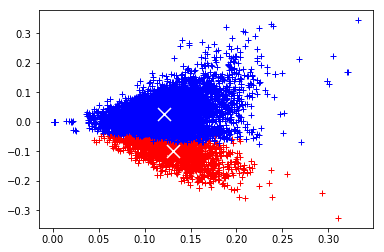

In [49]:
# use LSI w/ r=40
def plot_clusters(k, mode='lsi'):
    if mode is 'lsi':
        svd = TruncatedSVD(n_components=k)
    else:
        svd = NMF(n_components=k)
    X = svd.fit_transform(trainX)
    kmeans = KMeans(n_clusters=2).fit(X)
    svd2 = TruncatedSVD(n_components=2)
    X2 = svd2.fit_transform(X)

    x1 = X2[kmeans.labels_ == 0][:, 0]
    y1 = X2[kmeans.labels_ == 0][:, 1]
    plt.plot(x1,y1,'r+')
    x2 = X2[kmeans.labels_ == 1][:, 0]
    y2 = X2[kmeans.labels_ == 1][:, 1]
    plt.plot(x2, y2, 'b+')
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
    plt.show()

plot_clusters(k=40)

In [48]:
from matplotlib.colors import ListedColormap

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

#print(X.shape)
def plot_kmeans(X, km_model):
    #step size in mesh
    h=0.2

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

#    print(xx.shape, yy.shape)
    Z = km_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    #plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())

    #plt.show()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = km_model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-Means on reduced data showing centroids in white')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xlim(0, 0.4)
    #plt.ylim(-0.4, 0.4)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()

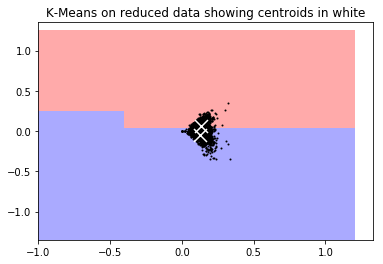

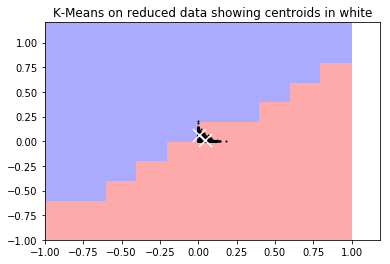

In [374]:
#X=scaled_train_lsi
#km_model = km
plot_kmeans(X=train_lsi, km_model=km)
plot_kmeans(X=train_nmf, km_model=km_nmf)



In [375]:
def sweep_metrics(train_vecs, names, km_model):
    #Store the different combinations
    contingency_matrices = []
    h_vals = []
    c_vals = []
    v_vals = []
    rand_vals = []
    mutual_vals = []
    
    for i in range(len(train_vecs)):
        print(names[i])
#         plot_kmeans(X=train_vecs[i], km_model=km_model)
        plot_clusters(X=train_vecs[i])
        contin, h, c, v, rand, mutual = get_nmf_scores(num_components=2, train_nmf=train_vecs[i], test_nmf=test_vecs[i])
        
        contingency_matrices.append(contin)
        h_vals.append(h)
        c_vals.append(c)
        v_vals.append(v)
        rand_vals.append(rand)
        mutual_vals.append(mutual)

    
    return (contingency_matrices, h_vals, c_vals, v_vals, rand_vals, mutual_vals)

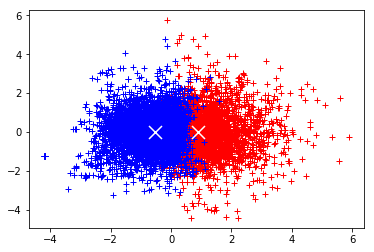

(array([[1489, 2414],
        [1398, 2581]]),
 0.00070661052447245612,
 0.00074549985271753509,
 0.00072553443622137771,
 0.00094710397895887688,
 0.00061512314662971659)

In [67]:
# LSI k=40, normalize

svd = TruncatedSVD(n_components=40)
# X = svd.fit_transform(trainX)
# print(X)
X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)
svd2 = TruncatedSVD(n_components=2)
X2 = svd2.fit_transform(X)

x1 = X2[kmeans.labels_ == 0][:, 0]
y1 = X2[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X2[kmeans.labels_ == 1][:, 0]
y2 = X2[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

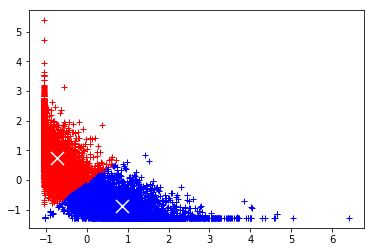

(array([[ 369, 3534],
        [3873,  106]]),
 0.68280383215740159,
 0.68564597521446458,
 0.68422195225245208,
 0.77344267746059059,
 0.68277479271669961)

In [81]:
# NMF k=40, normalize

svd = NMF(n_components=2)
# print(X)
X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)
# svd2 = TruncatedSVD(n_components=2)
# X2 = svd2.fit_transform(X)

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()

ypred = kmeans.predict(X)
get_scores(trainy, ypred)

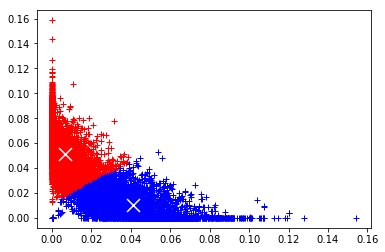

(array([[ 325, 3578],
        [3829,  150]]),
 0.676198943948499,
 0.6775820415392334,
 0.6768897862193376,
 0.77344265508849352,
 0.67616929984966179)

In [82]:
# NMF Log transformation
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=2), poly_transform)
X = nmf_norm_poly.fit_transform(trainX)
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)


x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

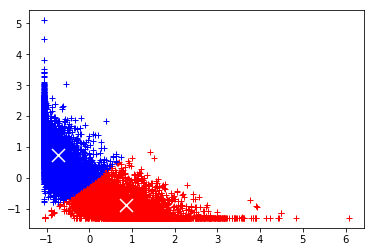

(array([[3536,  367],
        [ 106, 3873]]),
 0.68368793206160361,
 0.68649525835469682,
 0.68508871928580239,
 0.77433568617041104,
 0.68365897356118943)

In [83]:
# transform then scale
# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=2), poly_transform)
X = scale(nmf_norm_poly.fit_transform(trainX))
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

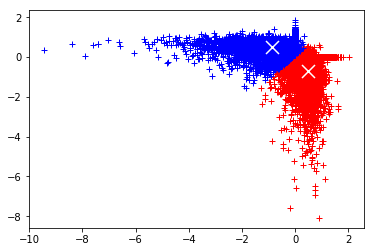

(array([[3615,  288],
        [ 227, 3752]]),
 0.65213449371188337,
 0.65238775535528004,
 0.65226109994930959,
 0.75569062945409626,
 0.65210264652287953)

In [84]:
# scale then transform
# print(X)
svd = NMF(n_components=2)
# print(X)
scaled = scale(svd.fit_transform(trainX))
# print(scaled)
poly_transform = FunctionTransformer(np.log1p)
X = np.nan_to_num(poly_transform.fit_transform(scaled))

kmeans = KMeans(n_clusters=2).fit(np.nan_to_num(X))

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

Normalized features


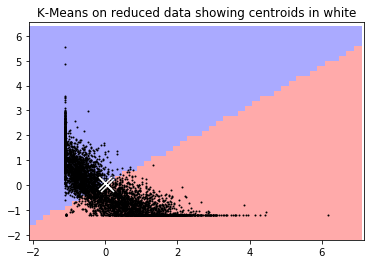

Non-linear log transform


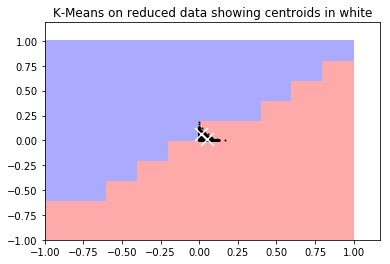

Log transform then normalization


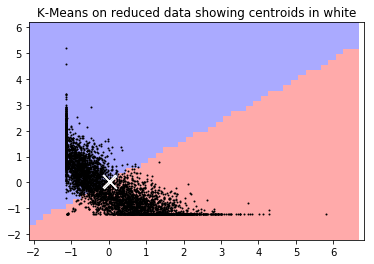

Normalization then log transform


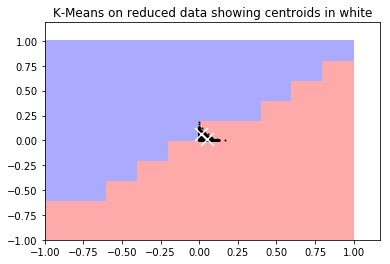

homogeneity=0.63576 
 completeness=0.63761 
 v-measure=0.63669 
 adj rand index=0.73570 
 adj mutual info=0.63568 
---
homogeneity=0.60663 
 completeness=0.60710 
 v-measure=0.60687 
 adj rand index=0.71300 
 adj mutual info=0.60654 
---
homogeneity=0.63363 
 completeness=0.63555 
 v-measure=0.63459 
 adj rand index=0.73352 
 adj mutual info=0.63355 
---
homogeneity=0.60298 
 completeness=0.60336 
 v-measure=0.60317 
 adj rand index=0.70978 
 adj mutual info=0.60289 
---
Determining best model...
[0, 0, 0, 0, 0]
('Best model #: ', 0)


In [377]:
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer


#Normalization only for NMF using previously generated nmf model
scaled_train_nmf = scale(train_nmf)
scaled_test_nmf = scale(test_nmf)


#Log transformation on NMF w/ no normalization 
nmf = NMF(n_components=2)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly =make_pipeline(nmf, poly_transform)

train_nmf_poly = nmf_norm_poly.fit_transform(trainX)
test_nmf_poly = nmf_norm_poly.transform(testX)

#Poly first then normalization 
train_poly_norm = scale(train_nmf_poly)
test_poly_norm = scale(test_nmf_poly)


#Normalization first then poly
train_norm_poly = poly_transform.fit_transform(train_nmf)
test_norm_poly = poly_transform.transform(test_nmf)

train = np.array([scaled_train_nmf, train_nmf_poly, train_poly_norm, train_norm_poly], dtype=float)
test = np.array([scaled_test_nmf, test_nmf_poly, test_poly_norm, test_norm_poly], dtype=float)
names = ['Normalized features', 'Non-linear log transform', 'Log transform then normalization', 'Normalization then log transform']


results = sweep_metrics(train, test, names, km_nmf)
contingency_matrices = results[0]
h_vals = results[1]
c_vals = results[2]
v_vals = results[3]
rand_vals = results[4]
mutual_vals = results[5]

for h, c, v, rand, mutual in zip(h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print(" homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (h, c, v, rand, mutual))
    

    
print("Determining best model...")
res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index



print("Best model #: ", best_index)




# Can you justify why logarithm transformation may increase the clustering results?
a logarithm transformation doesn't help...


# 5: Expand Dataset into 20 categories

In [379]:
from sklearn.feature_extraction.text import TfidfVectorizer 

all_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42,  remove=('headers','footers','quotes'))
tfidf = TfidfVectorizer(analyzer='word', stop_words=text.ENGLISH_STOP_WORDS, min_df=3)

all_data_tfidf = tfidf.fit_transform(all_data.data)

In [382]:
#get data labels
labels_all_data = all_data.target
print(labels_all_data[:20], len(labels_all_data))

(array([10,  3, 17,  3,  4, 12,  4, 10, 10, 19, 19, 11, 19, 13,  0, 17, 12,
       12, 11,  8]), 18846)


In [383]:
#Raw without dimensionality reduction 
km = KMeans(n_clusters=20)
km.fit(all_data_tfidf)

ytrue = labels_all_data
ypred = km.labels_

get_scores(ytrue, ypred)


(array([[  0,   0,   3, 310,   0,   2,   0,   5,   1,  15,  33,   0,  15,
           2, 267,  17,   0, 119,   7,   3],
        [  0,   0, 265,  61,  51,   0,   5,   1,   1,   0,  15,   0,  18,
           3, 265,  19,  36,   0, 140,  93],
        [ 19,   0,  79,  54,  70,   0,   1,   0,   0,   0,  15,   0,  28,
           1, 238,  10, 286,   1,  59, 124],
        [190,   0,  37,  42, 213,   2,   3,   0,   2,   0,  27,   1,  16,
           5, 270,  16,  42,   0, 104,  12],
        [106,   0,  35,  82, 141,   0,   3,   0,   1,   0,  12,   0,  20,
           1, 407,  19,   5,   0, 124,   7],
        [  1,   0, 457,  34,  10,   0,   5,   0,   0,   0,  17,   0,  21,
           9, 224,   7,  48,   0, 100,  55],
        [ 67,   0,  12,  31,  61,  32,  92,   0,  19,   0,  32,   5,   3,
           1, 500,  45,  19,   0,  55,   1],
        [  3,   0,   2, 123,   0, 316,   2,   0,   0,  11,  17,   0,  16,
           1, 405,  63,   0,   0,  30,   1],
        [ 14,   0,   0, 295,   0,  32,   1,   0,

In [385]:
# LSI w/ n_components = 2 and 40 
svd_2 = TruncatedSVD(n_components=2)
svd_40 = TruncatedSVD(n_components=40)

lsi_total_2 = svd_2.fit_transform(all_data_tfidf)
lsi_total_40 = svd_40.fit_transform(all_data_tfidf)

km_2 = KMeans(n_clusters=20)
km_2.fit(lsi_total_2)

km_40 = KMeans(n_clusters=20)
km_40.fit(lsi_total_40)

ypred_2 = km_2.labels_
ypred_40 = km_40.labels_



In [386]:
#get scores for 2
get_scores(ytrue, ypred_2)


(array([[ 78,   1,  59,  11,   2,   4, 117,   2,   0,  55, 132, 164,  21,
           0,  24,   0,  80,   4,   0,  45],
        [  7, 159,   0, 113,  50,  25,  31, 104,  61,  46,   0,   3,   0,
         115,   0,  13,   1,  52, 146,  47],
        [  7, 109,   0,  80,  58,   9,  20,  76, 179,  72,   1,   4,   0,
          86,   0,  50,   2,  25, 195,  12],
        [  2, 154,   0,  83,  80,  10,  10,  85, 119,  36,   0,   1,   0,
         138,   0,  35,   1,  23, 192,  13],
        [  1, 159,   0, 130,  92,  17,  20, 111,  39,  63,   0,   1,   1,
         129,   0,   4,   1,  57, 109,  29],
        [  4, 199,   0, 175,  43,   7,  11, 154,  34,  43,   0,   3,   0,
         143,   0,  18,   2,  36,  97,  19],
        [  6, 150,   0, 196,  26,   8,  37, 172,  56,  67,   0,   4,   0,
          73,   0,   5,   1,  39,  99,  36],
        [ 78,  12,   2,  99,   5,  36, 140,  72,   0, 118,   6,  39,   2,
          22,   0,   0,  11, 133,   3, 212],
        [ 96,   4,   0,  81,   0,  33, 202,  50,

In [387]:
#get scores for 40
get_scores(ytrue, ypred_40)

(array([[  7, 322,  83,   0,   2,   3,   0,   0,   0,   2,   5, 262,   0,
           0,  93,   2,   0,  18,   0,   0],
        [166, 290,   0,   0,   0,   0,   0,  54,   0, 257,  10,  71,   0,
          90,   0,   2,   0,   0,   4,  29],
        [ 72, 240,   1,   0,   0,   0,   0,  77,  16, 157,   5,  49,   0,
          56,   0,   0,   2,   1,   1, 308],
        [ 97, 189,   0,   0,   3,   0,   0, 168, 126,  30,   1,  32,   3,
         220,   0,   3,  70,   0,   1,  39],
        [ 96, 228,   0,   0,   0,   0,   0,  54,  85,  14,   4,  45,   1,
         400,   0,   1,  29,   0,   1,   5],
        [123, 290,   0,   0,   0,   0,   0,   7,   1, 441,   4,  41,   0,
          21,   0,   8,   0,   0,   4,  48],
        [ 46, 236,   0,   0,  26,   0,   0,  35,  59,   0,   1,  23,  15,
         453,   0,   0,   7,   0,  63,  11],
        [ 36, 436,   0,   0, 332,   0,   0,   0,   3,   4,   0, 147,   0,
          16,   2,   1,   0,  11,   2,   0],
        [ 36, 537,   2,   0,  45,   0,   0,   0,

LSI...
r: 1 
 homogeneity=0.01516 
 completeness=0.01648 
 v-measure=0.01579 
 adj rand index=0.00313 
 adj mutual info=0.01196 
---
r: 2 
 homogeneity=0.17440 
 completeness=0.18632 
 v-measure=0.18016 
 adj rand index=0.05036 
 adj mutual info=0.17173 
---
r: 3 
 homogeneity=0.21548 
 completeness=0.23676 
 v-measure=0.22562 
 adj rand index=0.06647 
 adj mutual info=0.21293 
---
r: 5 
 homogeneity=0.26561 
 completeness=0.29715 
 v-measure=0.28050 
 adj rand index=0.08719 
 adj mutual info=0.26323 
---
r: 10 
 homogeneity=0.27704 
 completeness=0.31739 
 v-measure=0.29584 
 adj rand index=0.08653 
 adj mutual info=0.27469 
---
r: 20 
 homogeneity=0.28841 
 completeness=0.35187 
 v-measure=0.31699 
 adj rand index=0.07260 
 adj mutual info=0.28609 
---
r: 40 
 homogeneity=0.27379 
 completeness=0.35105 
 v-measure=0.30764 
 adj rand index=0.06209 
 adj mutual info=0.27143 
---
r: 50 
 homogeneity=0.29119 
 completeness=0.38053 
 v-measure=0.32992 
 adj rand index=0.06287 
 adj mutual

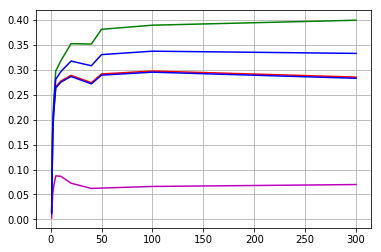

In [414]:
#Sweep LSI and NMF dimensions
r_vals = [1,2,3,5,10,20,40,50,100,300]
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
print("LSI...")
for r in r_vals:
    svd = TruncatedSVD(n_components=r)
    train_lsi = svd.fit_transform(all_data_tfidf)
        
    contin, h, c, v, rand, mutual = get_svd_scores(k=r, train_lsi=train_lsi, test_lsi=None, trainy=ytrue, n_clusters=20)
#    contingency_matrices.append(contin)
#    print("contingency matrix for r=", r)
#    print(h, c, v, rand, mutual)
 #   print(contin)
    contingency_matrices.append(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list)) # not sure if this works e.g. [0,1,0,3,2,0]
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()

NMF...
('r-value: ', 1)
('r-value: ', 2)
('r-value: ', 3)
('r-value: ', 5)
('r-value: ', 10)
('r-value: ', 20)
('r-value: ', 40)
('r-value: ', 50)
('r-value: ', 100)
('r-value: ', 300)
r: 1 
 homogeneity=0.01546 
 completeness=0.01666 
 v-measure=0.01604 
 adj rand index=0.00316 
 adj mutual info=0.01226 
---
r: 2 
 homogeneity=0.16135 
 completeness=0.17094 
 v-measure=0.16601 
 adj rand index=0.04657 
 adj mutual info=0.15863 
---
r: 3 
 homogeneity=0.18779 
 completeness=0.21056 
 v-measure=0.19852 
 adj rand index=0.05472 
 adj mutual info=0.18515 
---
r: 5 
 homogeneity=0.21922 
 completeness=0.26075 
 v-measure=0.23819 
 adj rand index=0.06541 
 adj mutual info=0.21666 
---
r: 10 
 homogeneity=0.26157 
 completeness=0.31635 
 v-measure=0.28636 
 adj rand index=0.07140 
 adj mutual info=0.25917 
---
r: 20 
 homogeneity=0.22945 
 completeness=0.29031 
 v-measure=0.25632 
 adj rand index=0.04733 
 adj mutual info=0.22694 
---
r: 40 
 homogeneity=0.17572 
 completeness=0.25540 
 v-me

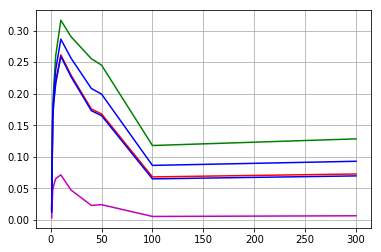

In [418]:
print("NMF...")   
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
# r_vals = [2,3,4,5]
for r in r_vals:
    print("r-value: ", r)
    nmf = NMF(n_components=r)
    train_nmf = nmf.fit_transform(all_data_tfidf)
        
    contin, h, c, v, rand, mutual = get_nmf_scores(num_components=r, train_nmf=train_nmf, test_nmf=None, trainy=ytrue, n_clusters=20)
    
 #   print("contingency matrix for r=", r)
#    print(contin)
    contingency_matrices.append(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))


res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()



